In [ ]:

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d salader/dogs-vs-cats


Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:27<00:00, 41.4MB/s]
100% 1.06G/1.06G [00:27<00:00, 42.2MB/s]


In [ ]:
import zipfile

# Open the zip file
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')

# Extract all the contents to the specified directory
zip_ref.extractall('/content')

# Close the zip file after extraction
zip_ref.close()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# generators
train_ds=keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds=keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# normalize
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)


In [26]:
# create cnn model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))



In [27]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
history= model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 79ms/step - accuracy: 0.5802 - loss: 2.6605 - val_accuracy: 0.6108 - val_loss: 0.6501
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.6914 - loss: 0.6038 - val_accuracy: 0.7394 - val_loss: 0.5256
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.7488 - loss: 0.5155 - val_accuracy: 0.7202 - val_loss: 0.5395
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.7939 - loss: 0.4450 - val_accuracy: 0.7874 - val_loss: 0.4741
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8311 - loss: 0.3864 - val_accuracy: 0.8020 - val_loss: 0.4285
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8673 - loss: 0.3023 - val_accuracy: 0.8110 - val_loss: 0.4623
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9016 - loss: 0.2479 - val_accuracy: 0.7944 - val_loss: 0.5959
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.9367 - loss: 0.1616 - 

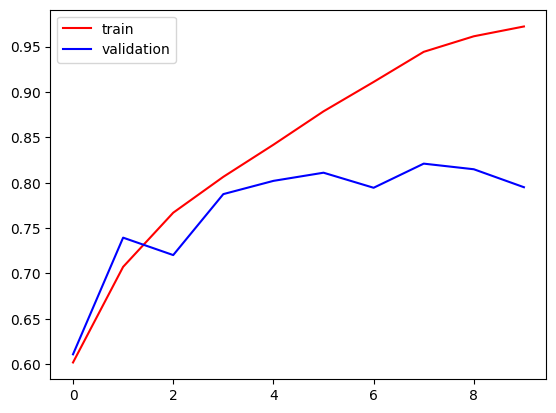

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

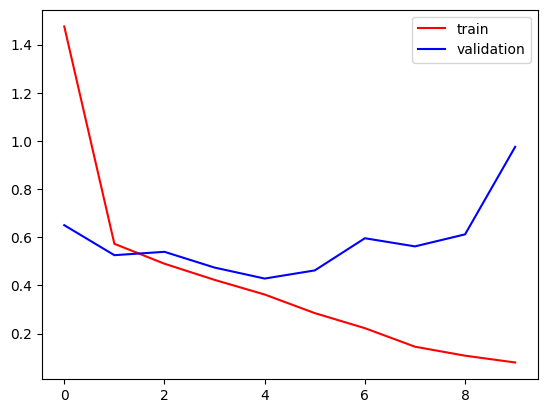

In [31]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()


In [ ]:
# ways to reduce overfitting

# add more data
# data  augmentation
# l1/l2 regularization
# droput
# batch norm
# reduce complexity

In [32]:
import cv2

In [33]:
test_img = cv2.imread('/content/dog.jpg')


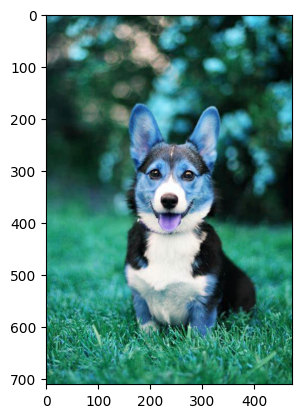

In [34]:
plt.imshow(test_img)

In [38]:
test_img.shape

(711, 474, 3)

In [39]:
test_img = cv2.resize(test_img,(256,256))

In [40]:
test_input= test_img.reshape((1,256,256,3))

In [41]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[1.]], dtype=float32)

In [42]:
test_img = cv2.imread('/content/cat.jpg')

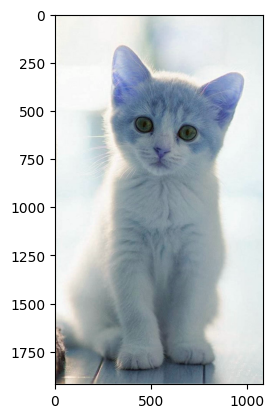

In [43]:
plt.imshow(test_img)


In [44]:
test_img.shape

(1920, 1080, 3)

In [45]:
test_img = cv2.resize(test_img,(256,256))

In [46]:
test_input= test_img.reshape((1,256,256,3))

In [47]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.]], dtype=float32)